In [ ]:
## load in packages
# Package names 
packages <- c("ISLR", "glmnet", "ggplot2", "readxl", "forecast", "MASS", "plyr", "dplyr", 
              "tibble", "zoo", "jtools", "sjmisc", "matrixStats", "PerformanceAnalytics", 
              "reshape2", "groupdata2", "tidyr", "caret", "ggfortify","Metrics", 
              "gbm", "PortfolioAnalytics", "devtools", "corrr", "rattle", "rpart",
              "skimr", "tensorflow", "keras", "doBy", "chron", "xtable", "caTools", 
              "data.table", "lubridate", "zoo", "stringr", "openxlsx", "tidyverse",
              "writexl", "xlsx", "rJava", "utils", "downloader", "readtext", 
              "prophet", "dtw", "mclust", "NbClust", "factoextra", "plotly", "htmlwidgets",
              "IRdisplay", "widgetframe", "repr")

# Install packages not yet installed 
installed_packages <- packages %in% rownames(installed.packages()) 

if (any(installed_packages == FALSE)) {   
  install.packages(packages[!installed_packages]) 
} 

# Packages loading
invisible(lapply(packages, library, character.only = TRUE))

# supress warnings 
options(warn=-1)

In [2]:
# load in data 
df <- as_tibble(read.csv("telemetrie.csv")[,-1]) %>% 
 mutate(Telemetry.ID = substring(Telemetry.ID, 14))

# check missing values
paste("number of missing values:", sum(is.na(df)))

[1] "number of missing values: 0"

In [3]:
# Perform scaling row wise and remove telemetry id column
df_scaled <- as_tibble(t(apply(df[,-1], 1, scale)))
paste("number of missing values:", sum(is.na(df_scaled)))    # why do i have missing values when i scale and center? 

[1] "number of missing values: 341952"

In [5]:
# extract all EANs that have missing values after center & scaling
df_scaled[unique(which(is.na(df_scaled ), arr.ind=TRUE)[,1]),]
# --> 13 EANs give missing values when center and scaling, just dismiss them for now since we have 12000 EANs

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V26295,V26296,V26297,V26298,V26299,V26300,V26301,V26302,V26303,V26304
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# put back correct EAN number for each row
rownames(df_scaled) <- df$Telemetry.ID

# after scaling, 13 EAN numbers have missing values, will just remove for now
df_scaled <- na.omit(df_scaled)

# set original df also so that it matches the EANs
df <- df[rownames(df_scaled) == rownames(df),]
head(df)

Telemetry.ID,X2019.01.01.00.00.00,X2019.01.01.01.00.00,X2019.01.01.02.00.00,X2019.01.01.03.00.00,X2019.01.01.04.00.00,X2019.01.01.05.00.00,X2019.01.01.06.00.00,X2019.01.01.07.00.00,X2019.01.01.08.00.00,...,X2021.12.31.14.00.00,X2021.12.31.15.00.00,X2021.12.31.16.00.00,X2021.12.31.17.00.00,X2021.12.31.18.00.00,X2021.12.31.19.00.00,X2021.12.31.20.00.00,X2021.12.31.21.00.00,X2021.12.31.22.00.00,X2021.12.31.23.00.00
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
871685900000000059,2324,2220,2192,2168,2056,1964,1780,1656,1616,...,2472,2432,2292,2220,2292,2268,2228,2036,1972,1780
871685900000000066,16,20,20,16,20,20,20,16,20,...,12,12,16,12,16,12,16,16,12,16
871685900000000103,104,108,108,120,364,592,540,1324,3212,...,5764,4752,5300,4924,5328,4640,3504,880,904,832
871685900000000110,1272,1320,1100,1184,1444,1752,2272,3660,5192,...,10420,9452,10888,9848,7836,5464,3052,820,592,528
871685900000000127,284,256,872,552,284,2164,2980,1560,1824,...,868,876,732,816,1208,892,672,156,100,100
871685900000000134,1304,1796,1848,1600,1460,1676,1968,3740,3748,...,8832,8048,8588,8044,7552,5728,3436,1200,916,908


## K-means clustering

In [ ]:
# use elbow method to define ideal numbers of cluster
fviz_nbclust(df_scaled, kmeans, method="wss", k.max = 50, verbose = T) + 
 labs(subtitle = "Elbow method")  

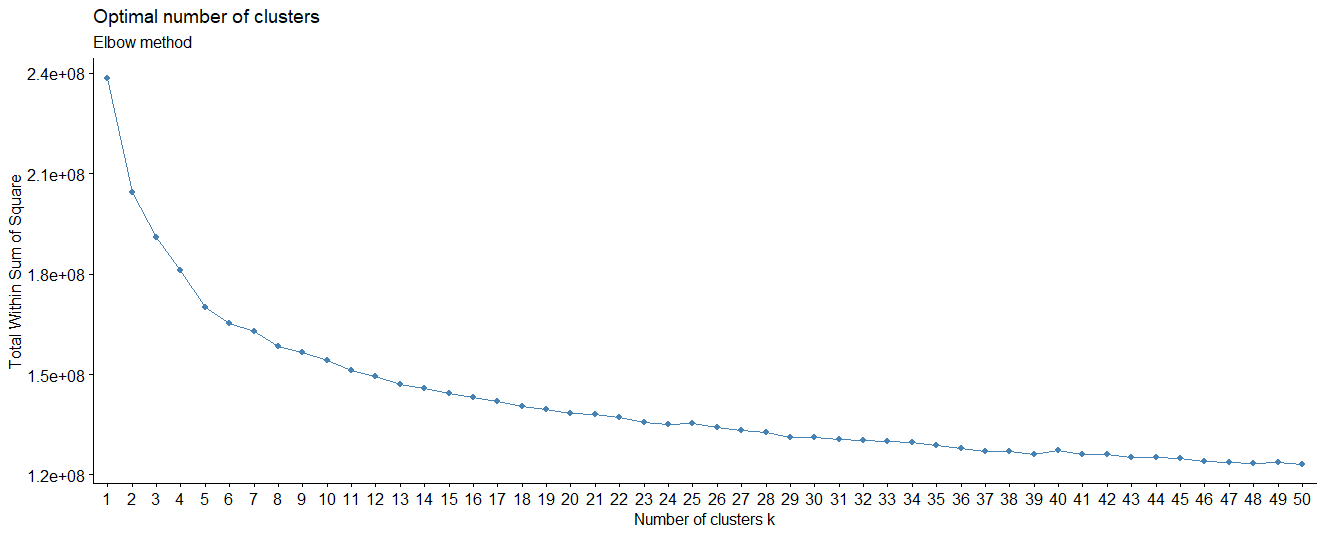

After discussing the above result with Annelies, we concluded that between 6 and 8 clusters should be sufficient for our analysis. We do not gain much more information after this if we increase the clusters. The trade-off between the number of clusters and the information we gain from the analysis will then diminish significantly. 

A better approach would be to use DTW (Dynamic Time Wrapping) instead of K-means clustering. However, using K-means clustering is much faster and less expensive computational wise. To use DTW, we will need more computing power, we will have to see whether we could use cloud computing power in order to conduct the analysis. 

To evaluate a K-means, we need to look at the calculation given by between_SS / total_SS, this gives us a measure of the goodness of fit the classification k-means has found.

In [ ]:
# initaite clustering for high number of clusters
km_20 <- kmeans(df_scaled, centers = 20)
km_30 <- kmeans(df_scaled, centers = 30)

In [ ]:
# measure for both clusters the total variance that is explained by the clustering.
paste("When having 20 clusters, between_SS / total_SS =", paste(round(km_20$betweenss/km_20$totss * 100), "%"),". ", 
"When having 30 clusters, between_SS / total_SS =", paste(round(km_30$betweenss/km_30$totss * 100), "%"))

[1] "When having 20 clusters, between_SS / total_SS = 42 % .  When having 30 clusters, between_SS / total_SS = 45 %"

In [5]:
# initaite clustering for suggested number of clusters
km_6 <- kmeans(df_scaled, centers = 6)
km_8 <- kmeans(df_scaled, centers = 8)

In [6]:
# measure for both clusters the total variance that is explained by the clustering.
paste("When having 6 clusters, between_SS / total_SS =", paste(round(km_6$betweenss/km_6$totss * 100), "%"),". ", 
"When having 8 clusters, between_SS / total_SS =", paste(round(km_8$betweenss/km_8$totss * 100), "%"))

[1] "When having 6 clusters, between_SS / total_SS = 31 % .  When having 8 clusters, between_SS / total_SS = 33 %"

Going from 6 clusters to 20 clusters, only gives us an increase of 10%, but this increase also makes it more complicated and computationally more expensive. On behalf of the advice of Annelies, I proceeded to use 6 clusters. 

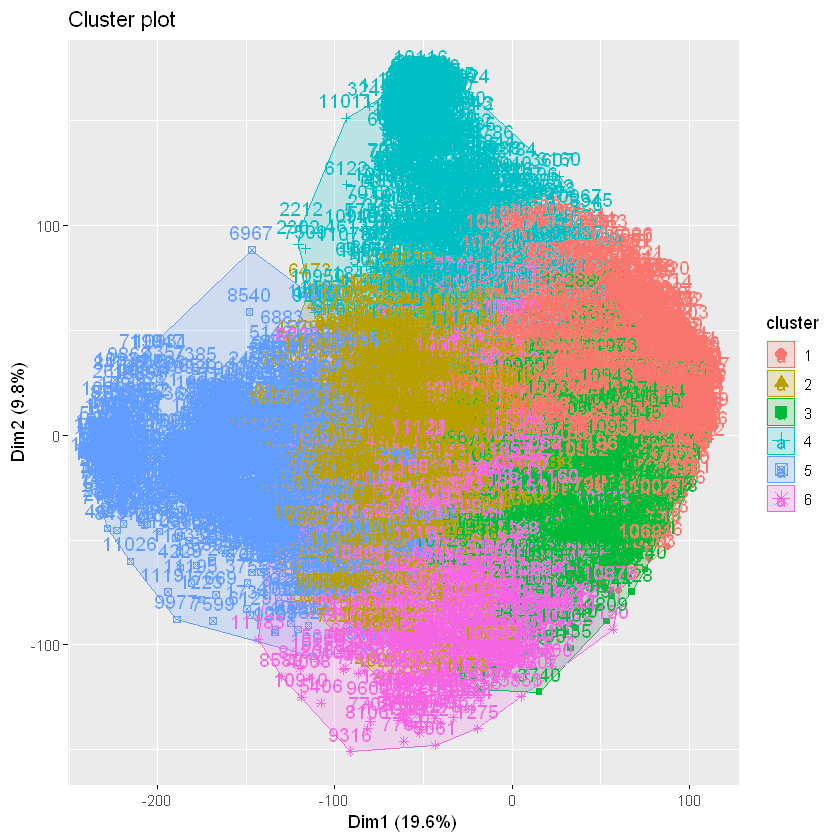

In [7]:
# visualize it using PCA (reducing it to two dimensions in which we show the cluster mapping)
km_clusters <- km_6$cluster
fviz_cluster(list(data=df_scaled, cluster= km_clusters))

In [9]:
# make final df in which I show each telemetry ID with its cluster
df_final <- as_tibble(cbind(Cluster = km_clusters, df))

# aggregate on clusters 
df_aggregated <- df_final %>%
  group_by(Cluster ) %>%
    summarise_at(vars(-Telemetry.ID), funs(mean(., na.rm=TRUE)))
head(df_aggregated)

Cluster,X2019.01.01.00.00.00,X2019.01.01.01.00.00,X2019.01.01.02.00.00,X2019.01.01.03.00.00,X2019.01.01.04.00.00,X2019.01.01.05.00.00,X2019.01.01.06.00.00,X2019.01.01.07.00.00,X2019.01.01.08.00.00,...,X2021.12.31.14.00.00,X2021.12.31.15.00.00,X2021.12.31.16.00.00,X2021.12.31.17.00.00,X2021.12.31.18.00.00,X2021.12.31.19.00.00,X2021.12.31.20.00.00,X2021.12.31.21.00.00,X2021.12.31.22.00.00,X2021.12.31.23.00.00
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,234.7953,236.7302,236.3980,237.0991,240.0000,250.7202,274.0543,330.0834,385.9395,...,507.9036,501.5033,497.7987,497.1420,475.5637,457.5767,386.3284,299.4933,280.1439,272.1959
2,155.4811,156.4600,156.0963,156.6801,157.5174,163.3160,173.8909,194.0324,212.0963,...,246.3509,241.1184,241.0968,234.6084,227.8113,217.1047,189.8359,160.2713,152.6722,149.6649
3,161.6134,160.1279,159.5990,160.5647,160.1706,164.3469,177.8381,196.1429,204.8931,...,228.4172,225.8980,223.2486,216.2558,205.3460,196.1948,181.1731,161.7712,153.4140,150.9502
4,243.6065,244.7181,238.3935,235.0872,235.2495,239.6755,244.6694,261.7890,273.5294,...,268.7586,263.4848,260.5720,261.4645,252.7099,241.7890,226.3164,204.1582,192.1542,187.3509
5,142.8586,140.9152,138.3856,141.0180,140.6821,142.1354,151.0848,166.6564,192.3736,...,237.4979,239.4070,232.3770,223.2665,220.0480,209.3813,187.5133,165.5835,157.4876,150.6701
6,355.4082,355.9006,353.4730,353.6803,357.1058,359.1836,368.2117,382.8294,397.2829,...,539.1015,534.2160,527.9309,519.1361,510.6393,499.6328,480.1814,473.7883,463.4989,453.7408


In [10]:
## make dataframe such that it is a time-series again 
df_summ <- as_tibble(t(df_aggregated))
colnames(df_summ) <- paste("Cluster", as.character(df_summ[1,]))
df_summ <- df_summ[-1,]

# add date column
df_summ <- cbind(date= seq(as.POSIXct("2019/01/01 00:00:00"), 
                    as.POSIXct("2021/12/31 23:00:00"), by = "1 hour"), df_summ)
head(df_summ)

,date,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-01-01 00:00:00,234.7953,155.4811,161.6134,243.6065,142.8586,355.4082
2,2019-01-01 01:00:00,236.7302,156.4600,160.1279,244.7181,140.9152,355.9006
3,2019-01-01 02:00:00,236.3980,156.0963,159.5990,238.3935,138.3856,353.4730
4,2019-01-01 03:00:00,237.0991,156.6801,160.5647,235.0872,141.0180,353.6803
5,2019-01-01 04:00:00,240.0000,157.5174,160.1706,235.2495,140.6821,357.1058
6,2019-01-01 05:00:00,250.7202,163.3160,164.3469,239.6755,142.1354,359.1836


In [11]:
#overgang van zomer naar wintertijd. Klok gaat 1 uur vooruit dus in praktijk heb je het uur van 2:00-3:00 niet.
# dus deze datapunten mogen verwijderd worden
df_aggregated[,-1] %>% 
  select(where(is.numeric)) %>% 
  select(where(~sum(.) == 0))
# -->need to remove: 2019.03.31 03.00.00 / 2020.03.29 03.00.00 / 2021.03.28 03.00.00 (these hours actually don't exist) 

df_summ <- df_summ %>% filter(date != "2019-03-31 03:00:00" & date != "2020-03-29 03:00:00"
                   & date != "2021-03-28 03:00:00")

X2019.03.31.02.00.00,X2020.03.29.02.00.00,X2021.03.28.02.00.00
<dbl>,<dbl>,<dbl>
0,0,0
0,0,0
0,0,0
0,0,0
0,0,0
0,0,0


## Plotting clusters

In [13]:
# cluster 1
cluster1_plot <- plot_ly(x = df_summ[,1], y = df_summ[,2], 
                         type = 'scatter', mode = 'lines') %>% 
  layout(title= "Mean of cluster 1", xaxis = list(title = 'Date'), 
         yaxis = list(title = 'Mean offtake'))

saveWidget(cluster1_plot, "cluster1.html", selfcontained = T )
display_html('<iframe src="cluster1.html" width=100% height=400></iframe>')         

In [12]:
# cluster 2
cluster2_plot <- plot_ly(x = df_summ[,1], y = df_summ[,3], type = 'scatter', mode = 'lines') %>% 
  layout(title= "Mean of cluster 2", xaxis = list(title = 'Date'), 
         yaxis = list(title = 'Mean offtake'))

saveWidget(cluster2_plot, "cluster2.html", selfcontained = T )
display_html('<iframe src="cluster2.html" width=100% height=400></iframe>')   


In [14]:
# cluster 3
cluster3_plot <- plot_ly(x = df_summ[,1], y = df_summ[,4], type = 'scatter', mode = 'lines') %>% 
  layout(title= "Mean of cluster 3", xaxis = list(title = 'Date'), 
         yaxis = list(title = 'Mean offtake'))

saveWidget(cluster3_plot, "cluster3.html", selfcontained = T )
display_html('<iframe src="cluster3.html" width=100% height=400></iframe>')   

In [15]:
# cluster 4
cluster4_plot <- plot_ly(x = df_summ[,1], y = df_summ[,5], type = 'scatter', mode = 'lines') %>% 
  layout(title= "Mean of cluster 4", xaxis = list(title = 'Date'), 
         yaxis = list(title = 'Mean offtake'))

saveWidget(cluster4_plot, "cluster4.html", selfcontained = T )
display_html('<iframe src="cluster4.html" width=100% height=400></iframe>')   

In [16]:
# cluster 5
cluster5_plot <- plot_ly(x = df_summ[,1], y = df_summ[,6], type = 'scatter', mode = 'lines') %>% 
  layout(title= "Mean of cluster 5", xaxis = list(title = 'Date'), 
         yaxis = list(title = 'Mean offtake'))

saveWidget(cluster5_plot, "cluster5.html", selfcontained = T )
display_html('<iframe src="cluster5.html" width=100% height=400></iframe>')   

In [17]:
# cluster 6
cluster6_plot <- plot_ly(x = df_summ[,1], y = df_summ[,7], type = 'scatter', mode = 'lines') %>% 
  layout(title= "Mean of cluster 6", xaxis = list(title = 'Date'), 
         yaxis = list(title = 'Mean offtake'))

saveWidget(cluster6_plot, "cluster6.html", selfcontained = T )
display_html('<iframe src="cluster6.html" width=100% height=400></iframe>')   